In [1]:
import re
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG

In [2]:
from model.utils import set_seed
from model.model import GPT, GPTConfig
from model.trainer import Trainer, TrainerConfig
from model.utils import sample

import torch
from torch.nn import functional as F
from torch.utils.data import Dataset

In [3]:
# set up logging
import logging
logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO,
)

In [4]:
# make deterministic
set_seed(42)

In [5]:
class CharDataset(Dataset):
    def __init__(self, data, block_size):
        chars = []
        for i in text:
            for j in set(i):
                chars.append(j)           
        chars = sorted(list(set(chars))) + ['<pad>']
        data_size, vocab_size = len(text), len(chars)
        print('Data has %d SMILES \n%d unique characters.' % (data_size, vocab_size))        
        self.stoi = {ch:i for i,ch in enumerate(chars)}
        self.itos = {i:ch for i,ch in enumerate(chars)}
        self.vocab_size = vocab_size
        self.data = data
        self.block_size = block_size
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        chunk = self.data[idx:idx + 1][0]
        dix = [self.stoi[s] for s in chunk] + [self.stoi['<pad>']] * (self.block_size - len(chunk))
        x = torch.tensor(dix[:-1], dtype=torch.long)
        y = torch.tensor(dix[1:], dtype=torch.long)
        return x, y

In [7]:
block_size = 64
text = [i.strip() for i in open('./data/s_train.txt', 'r').readlines()]
train_dataset = CharDataset(text, block_size)

Data has 2000 SMILES 
21 unique characters.


In [12]:
mconf = GPTConfig(train_dataset.vocab_size, train_dataset.block_size,
                  n_layer=12, n_head=12, n_embd=768)
model = GPT(mconf)

12/28/2021 03:34:29 - INFO - model.model -   number of parameters: 8.513741e+07


In [13]:
model.load_state_dict(torch.load('./ckpt/model.pt'))

<All keys matched successfully>

In [15]:
tconf = TrainerConfig(max_epochs=100, batch_size=512, learning_rate=6e-4,
                      lr_decay=True, warmup_tokens=512*20, final_tokens=2*len(train_dataset)*block_size)
trainer = Trainer(model, train_dataset, None, tconf)
# trainer.train()

In [21]:
def moltosvg(mol, molSize = (300,300), kekulize = True):
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        rdDepictor.Compute2DCoords(mc)
    drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
    drawer.DrawMolecule(mc)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    return svg.replace('svg:','')

O=C(Nc1ncccc1)c1ccccc1<pad><pad><pad><pad>


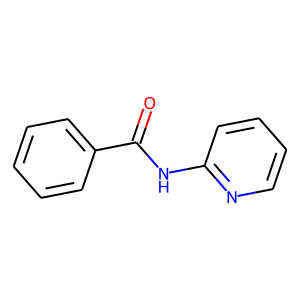

In [157]:
context = "O"
x = torch.tensor([train_dataset.stoi[s] for s in context], dtype=torch.long)[None,...].to(trainer.device)
y = sample(model, x, 25, temperature=1.0, sample=True, top_k=10)[0]
completion = ''.join([train_dataset.itos[int(i)] for i in y])
print(completion)

smiles = re.sub("<pad>","",completion)
SVG(moltosvg(Chem.MolFromSmiles(smiles)))